In [1]:
import matplotlib.pyplot as plt
from teyssier.sedov import sedovana

In [2]:
dim = 1
E0 = 100
rho0 = 1
T = 0.05

r, d, u, p = sedovana(gamma=1.6667, dim=dim)

r *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (2.0 / (dim + 2))
d *= rho0
u *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (-dim / (dim + 2))
p *= (E0 / rho0) ** (2.0 / (dim + 2)) * T ** (-2 * dim / (dim + 2)) * rho0

chi0=np.float64(1.1800317894447785)


(0.0, 1.0)

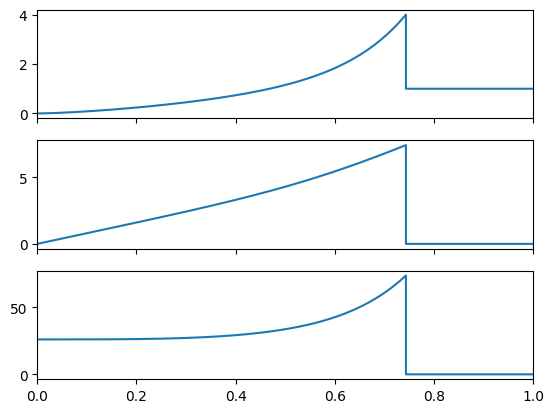

In [3]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(r, d)
axs[1].plot(r, u)
axs[2].plot(r, p)

axs[2].set_xlim(0, 1)